# 1. Basic Information Extraction


In [1]:
!pip install --upgrade pip
!pip install dpkt pandas scikit-learn

  Using cached dpkt-1.9.8-py3-none-any.whl.metadata (1.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.0 MB/s eta 0:00:00a 0:00:01
Using cached dpkt-1.9.8-py3-none-any.whl (194 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 799.0 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 925.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 1.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 1.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 1.1 MB/s eta 0:00:0000:0100:01


The following code snippet is a Python script that reads a packet capture (pcap) file, extracts basic features (i.e., source and destination IP addresses, protocol, TTL (Time To Live), port numbers, TCP flags, sequence numbers, packet size, payload size, and a label indicating whether the packet is considered malicious (label=1) or benign (label=0)) from the packets, and then saves this information into a CSV file (i.e., extracted_data.csv).

In [1]:
import dpkt
import socket
import pandas as pd

# Open the pcap file
with open('../dataset1.pcap', 'rb') as f:
    pcap = dpkt.pcap.Reader(f)

    data = []

    while True:
        try:
            timestamp, buf = next(pcap)
            try:
                eth = dpkt.ethernet.Ethernet(buf)

                # Check for VLAN
                if eth.type == 0x8100: # VLAN tag type
                    eth = dpkt.ethernet.Ethernet(eth.data)

                if not isinstance(eth.data, dpkt.ip.IP):
                    continue  # Skip non-IPv4 packets

                ip = eth.data

                ip_src = socket.inet_ntoa(ip.src)
                ip_dst = socket.inet_ntoa(ip.dst)
                protocol = ip.p
                ttl = ip.ttl
                packet_size = len(buf) # Total length of the packet (including all headers and payload)

                # Initialize as 0
                ack_flag = syn_flag = fin_flag = psh_flag = urg_flag = rst_flag = 0
                src_port = dst_port = sequence = acknowledgment = 0
                udp_flag = tcp_flag = 0
                payload_size = 0
                label = 0

                # Check for TCP
                if ip.p == dpkt.ip.IP_PROTO_TCP and isinstance(ip.data, dpkt.tcp.TCP):
                    tcp = ip.data
                    ack_flag = 1 if (tcp.flags & dpkt.tcp.TH_ACK) else 0
                    syn_flag = 1 if (tcp.flags & dpkt.tcp.TH_SYN) else 0
                    fin_flag = 1 if (tcp.flags & dpkt.tcp.TH_FIN) else 0
                    psh_flag = 1 if (tcp.flags & dpkt.tcp.TH_PUSH) else 0
                    urg_flag = 1 if (tcp.flags & dpkt.tcp.TH_URG) else 0
                    rst_flag = 1 if (tcp.flags & dpkt.tcp.TH_RST) else 0
                    src_port = tcp.sport
                    dst_port = tcp.dport
                    sequence = tcp.seq
                    acknowledgment = tcp.ack
                    tcp_flag = 1
                    payload_size = ip.len - ip.hl * 4 - tcp.off * 4

                # Check for UDP
                elif ip.p == dpkt.ip.IP_PROTO_UDP and isinstance(ip.data, dpkt.udp.UDP):
                    udp = ip.data
                    src_port = udp.sport
                    dst_port = udp.dport
                    udp_flag = 1
                    payload_size = ip.len - ip.hl * 4 - 8  # 8 bytes for UDP header

                # Create Label column: 1 (malicious) if src or dst port is 9, 0 (benign) otherwise
                label = 1 if src_port == 9 or dst_port == 9 else 0

                data.append({
                    'Timestamp': timestamp,
                    'Source': ip_src,
                    'Destination': ip_dst,
                    'Protocol': protocol,
                    'SrcPort': src_port,
                    'DstPort': dst_port,
                    'TCP': tcp_flag,
                    'UDP': udp_flag,
                    'TTL': ttl,
                    'ACK': ack_flag,
                    'SYN': syn_flag,
                    'FIN': fin_flag,
                    'PSH': psh_flag,
                    'URG': urg_flag,
                    'RST': rst_flag,
                    'SequenceNumber': sequence,
                    'AcknowledgmentNumber': acknowledgment,
                    'PacketSize': packet_size,
                    'PayloadSize': payload_size,
                    'Label': label
                })
            except Exception as e:
                    print(f"Error processing packet at timestamp {timestamp}: {e}")
                    continue  # Skip this problematic packet

        except StopIteration:
            break  # End of pcap file

        except dpkt.dpkt.NeedData as e:
            print(f"Truncated packet at timestamp {timestamp}: {e}")
            continue

        except Exception as e:
            print(f"Error processing packet: {e}")
            # Print the entire packet bytes (in hex format)
            # print(f"Packet Bytes: {buf.hex()}")
            continue  # Skip problematic packets

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)
    print("\nDataFrame created.")
    print ('O Label Count = ',len(df[df.Label==0]))
    print ('1 Label Count = ',len(df[df.Label==1]))

    # Save to a CSV file
    df.to_csv('extracted_data.csv', index=False)
    print("\nProcessing complete. Saved to CSV file.")


DataFrame created.
O Label Count =  956457
1 Label Count =  715341

Processing complete. Saved to CSV file.


Estraggo il testSet

In [2]:
import dpkt
import socket
import pandas as pd

# File PCAP per il test
with open('testSet/testSet_DDoS.pcap', 'rb') as f:
    pcap = dpkt.pcap.Reader(f)

    data = []

    while True:
        try:
            timestamp, buf = next(pcap)
            try:
                eth = dpkt.ethernet.Ethernet(buf)

                if eth.type == 0x8100: 
                    eth = dpkt.ethernet.Ethernet(eth.data)

                if not isinstance(eth.data, dpkt.ip.IP):
                    continue

                ip = eth.data
                ip_src = socket.inet_ntoa(ip.src)
                ip_dst = socket.inet_ntoa(ip.dst)
                protocol = ip.p
                ttl = ip.ttl
                packet_size = len(buf)

                ack_flag = syn_flag = fin_flag = psh_flag = urg_flag = rst_flag = 0
                src_port = dst_port = sequence = acknowledgment = 0
                udp_flag = tcp_flag = 0
                payload_size = 0
                label = 0

                if ip.p == dpkt.ip.IP_PROTO_TCP and isinstance(ip.data, dpkt.tcp.TCP):
                    tcp = ip.data
                    ack_flag = 1 if (tcp.flags & dpkt.tcp.TH_ACK) else 0
                    syn_flag = 1 if (tcp.flags & dpkt.tcp.TH_SYN) else 0
                    fin_flag = 1 if (tcp.flags & dpkt.tcp.TH_FIN) else 0
                    psh_flag = 1 if (tcp.flags & dpkt.tcp.TH_PUSH) else 0
                    urg_flag = 1 if (tcp.flags & dpkt.tcp.TH_URG) else 0
                    rst_flag = 1 if (tcp.flags & dpkt.tcp.TH_RST) else 0
                    src_port = tcp.sport
                    dst_port = tcp.dport
                    sequence = tcp.seq
                    acknowledgment = tcp.ack
                    tcp_flag = 1
                    payload_size = ip.len - ip.hl * 4 - tcp.off * 4

                elif ip.p == dpkt.ip.IP_PROTO_UDP and isinstance(ip.data, dpkt.udp.UDP):
                    udp = ip.data
                    src_port = udp.sport
                    dst_port = udp.dport
                    udp_flag = 1
                    payload_size = ip.len - ip.hl * 4 - 8 

                label = 1 if src_port == 9 or dst_port == 9 else 0

                data.append({
                    'Timestamp': timestamp,
                    'Source': ip_src,
                    'Destination': ip_dst,
                    'Protocol': protocol,
                    'SrcPort': src_port,
                    'DstPort': dst_port,
                    'TCP': tcp_flag,
                    'UDP': udp_flag,
                    'TTL': ttl,
                    'ACK': ack_flag,
                    'SYN': syn_flag,
                    'FIN': fin_flag,
                    'PSH': psh_flag,
                    'URG': urg_flag,
                    'RST': rst_flag,
                    'SequenceNumber': sequence,
                    'AcknowledgmentNumber': acknowledgment,
                    'PacketSize': packet_size,
                    'PayloadSize': payload_size,
                    'Label': label
                })
            except Exception as e:
                print(f"Errore nel processare il pacchetto al timestamp {timestamp}: {e}")
                continue

        except StopIteration:
            break

        except dpkt.dpkt.NeedData as e:
            print(f"Pacchetto troncato al timestamp {timestamp}: {e}")
            continue

        except Exception as e:
            print(f"Errore nel processare il pacchetto: {e}")
            continue

    # Salvataggio in CSV per il Test
    df_test = pd.DataFrame(data)
    df_test.to_csv('test_data.csv', index=False)
    print(f"Dati di test salvati in test_data.csv.")


Errore nel processare il pacchetto al timestamp 1554199850.965483: got 1, 3 needed at least
Errore nel processare il pacchetto al timestamp 1554200391.644523: got 1, 3 needed at least
Errore nel processare il pacchetto al timestamp 1554202598.889559: got 1, 3 needed at least
Errore nel processare il pacchetto al timestamp 1554203117.152048: got 1, 3 needed at least
Errore nel processare il pacchetto al timestamp 1554217385.290134: got 1, 3 needed at least
Errore nel processare il pacchetto al timestamp 1554217581.58632: got 1, 3 needed at least
Errore nel processare il pacchetto al timestamp 1554218329.83069: got 1, 3 needed at least
Dati di test salvati in test_data.csv.


# 2. Statistical Feature Extraction

This Python code utilizes the pandas library to read data from a CSV file named 'extracted_data.csv' and load it into a DataFrame, which is a two-dimensional labeled data structure with columns of potentially different data types.

In [3]:
import pandas as pd
df = pd.read_csv('extracted_data.csv')
df.head()

,Timestamp,Source,Destination,Protocol,SrcPort,DstPort,TCP,UDP,TTL,ACK,SYN,FIN,PSH,URG,RST,SequenceNumber,AcknowledgmentNumber,PacketSize,PayloadSize,Label
0,0.088028,10.0.0.6,10.0.0.2,6,59330,23,1,0,64,0,1,0,0,0,0,2725488704,0,78,0,0
1,0.088184,10.0.0.2,10.0.0.6,6,23,59330,1,0,64,1,1,0,0,0,0,3412483242,2725488705,78,0,0
2,0.088319,10.0.0.6,10.0.0.2,6,59330,23,1,0,64,1,0,0,0,0,0,2725488705,3412483243,70,0,0
3,0.088396,10.0.0.6,10.0.0.2,6,59330,23,1,0,64,1,0,0,1,0,0,2725488705,3412483243,74,4,0
4,0.088533,10.0.0.2,10.0.0.6,6,23,59330,1,0,64,1,0,0,0,0,0,3412483243,2725488709,70,0,0


### 2.1 Periodic Statistical Features

In the context of developing an Intrusion Detection System (IDS) for identifying Mirai botnet Distributed Denial of Service (DDoS) attacks such as ACK Flood, SYN Flood, and UDP Flood, the extraction of 24 statistical features from network packet data plays a pivotal role. Each feature provides unique insights into the traffic patterns and anomalies, thereby aiding in the effective detection of these attacks. Below is a description of how each feature is calculated and their rationale:



---

### Feature Descriptions for DDoS Traffic Detection


1. **Packet Counts**: This feature represents the total number of packets observed in each time window (group). In the context of DDoS attack detection, a sudden increase in the packet count can be a significant indicator of an attack. DDoS attacks like SYN Flood or UDP Flood often generate a large volume of packets in a short period, aiming to overwhelm the target system's resources. Monitoring the packet count helps in identifying such abnormal spikes in network traffic, which are characteristic of these types of attacks.

2. **Destination Port Entropy**: This feature is calculated by first counting the occurrences of each destination port (`DstPort`) in a time window, then determining the probability distribution of these ports, and finally calculating the entropy of this distribution. High entropy in destination ports may indicate scanning activity, a common precursor to DDoS attacks.

3. **Most Frequent Source Port**: Identifies the source port (`SrcPort`) that occurs most frequently within a window, if it exceeds a predefined threshold. In DDoS attacks, source ports might be spoofed or concentrated, and this feature helps in identifying such anomalies.

4. **Most Frequent Destination Port**: Similar to the most frequent source port, this feature identifies the most commonly targeted destination port. DDoS attacks often target specific ports on a host, making this a crucial feature for detection.

5. **Short-lived Connections**: Counts the number of connections that are short-lived, based on a predefined threshold on packet size. DDoS attacks often initiate numerous short-lived connections to overwhelm a target.

6. **Repeated Connection Attempts**: Measures the number of duplicated destination addresses within a group, indicative of repeated attempts to establish a connection, which can be a sign of an attack.

7. **Network Scanning Activity**: Counts instances where the SYN flag is set but the ACK flag is not, indicating a potential scanning activity, which is often a precursor to more aggressive attacks.

8. **Flow Rate**: Calculated as packets per second within each window, providing insight into the intensity of traffic, which can spike during DDoS attacks.

9. **Source Entropy**: Measures the entropy of source addresses within a window. High entropy might indicate spoofed or randomized sources, common in botnet behavior.

10. **Connection Errors (RST flag)**: Counts the instances of RST flag being set, indicating connection resets, which can be frequent in disrupted networks under DDoS attack.

11. **Most Frequent Packet Size Frequency**: Identifies the most commonly occurring packet size. DDoS attacks often use uniform packet sizes for flooding.

12. **Abnormal Size Frequency**: Counts packets that exceed a certain size threshold, useful for detecting payloads that are anomalously large, potentially indicative of certain types of attacks.

13. **Sequence Number Variance**: Measures the variance in sequence numbers of packets, as irregularities in this pattern can suggest spoofing or session hijacking attempts.

14. **Average Packet Number**: The average number of packets per defined processing interval. A sudden increase can indicate a flood attack.

15. **SYN Frequency**: The frequency of SYN flag occurrences, divided by the processing interval. Elevated levels can indicate SYN flood attacks.

16. **ACK Frequency**: Similar to SYN frequency, but for ACK flags. High frequencies can be indicative of ACK flood attacks.

17. **TCP Frequency**: The proportion of TCP packets within a window. Since many DDoS attacks exploit TCP protocols, this metric is vital.

18. **UDP Frequency**: The proportion of UDP packets, important for detecting UDP flood attacks.

19. **Most Frequent Protocol**: Identifies the most used protocol within a window. A sudden shift in protocol usage can signal an ongoing attack.

20. **Packet Size Variability**: The variance in packet sizes, as attacks often disrupt the normal distribution of packet sizes.

21. **Most Frequent Payload Size**: Detects the most common payload size within a window. Consistency in payload sizes can be a characteristic of automated attack tools.

22. **Average Payload Size**: The mean size of payloads, providing a baseline for detecting deviations typical in flood attacks.

22. **Packet Size Standard Deviation**: The standard deviation of packet sizes within each time window provides insights into the variability of packet sizes. In normal network traffic, packet sizes can vary but usually within a predictable range. However, during DDoS attacks, especially those employing large or irregularly sized packets (like certain UDP Flood attacks), this variability can increase significantly. High standard deviation in packet sizes during a short window can thus be a potential indicator of anomalous traffic patterns associated with DDoS attacks.

24. **Average Packet Size**: This feature calculates the mean size of packets within each time window. Mirai botnet attacks can sometimes be characterized by the uniformity of packet sizes, especially in scenarios where attackers use similar or identical packets to flood a network. Conversely, some attack vectors may use packets of varying sizes to evade detection. Therefore, the average packet size, when observed in conjunction with other features like packet count and variability, can provide valuable context. A notable deviation from the typical average packet size in a network could be indicative of an ongoing attack.

**Note**
The incorporation of a threshold in some of these features is crucial. It ensures the statistical significance of the calculated feature, mitigating the risk of false positives arising from random or evenly distributed usage of this feature in benign traffic. This threshold-based approach enhances the robustness of the features, thereby improving the overall accuracy and reliability of the IDS in detecting botnet DDoS attacks.

In essence, these features serve to capture different dimensions of the traffic profile within defined time windows. By analyzing them in tandem, an IDS can more effectively discern between normal network behavior and traffic patterns that are symptomatic of DDoS attacks. For instance, a combination of high packet counts, increased variability in packet sizes, and deviations in average packet size can collectively point towards the likelihood of a Mirai botnet DDoS attack. These statistical measures enable a nuanced approach to detecting and responding to such threats, enhancing the efficacy of the IDS in safeguarding network infrastructures.

---

### Importance in DDoS Detection

These features are designed to capture various aspects of network traffic that deviate from normal patterns and are characteristic of DDoS attacks. By analyzing these features over fixed time windows (e.g., every 20 seconds), it's possible to detect sudden changes in network behavior indicative of an attack. The use of time windows allows for near real-time detection, crucial for effective mitigation of DDoS attacks.

The following code is part of the data processing pipeline for network packet data analysis. Particularly  it prepares the network packet data by grouping packets into time intervals, calculating time differences between packets, and setting up thresholds for anomaly detection or other analysis tasks.

**Data Preparation:**

*   Creaties a copy of the DataFrame df as df_tmp for manipulation.

*   Sets up various parameters such as ***processing_interval*** (time interval for aggregating packets), ***abnormal_size_threshold*** (threshold for abnormal packet size), ***port_frequency_threshold*** (threshold for port frequency), and ***short_lived_threshold*** (threshold for short-lived connections).

* Ensures that the 'Timestamp' column is in the proper datetime format using pd.to_datetime().

* Converts the 'Timestamp' to seconds since the minimum timestamp in the dataset to standardize time representation.

* Groups packets every processing_interval seconds using integer division and adds 1 to start the group IDs from 1.

**Time Difference Calculation:**

*   Sorts the DataFrame by 'Timestamp' to ensure proper ordering.
*   Calculates the time difference ('TimeDiff') in seconds between consecutive packet timestamps using .diff() method.
*   Fills any NaN values with 0 as the first packet in a group has no time difference.


***GroupID***

In the provided code, GroupID is a new column created in the DataFrame df_tmp. It is used to group packets based on time intervals defined by the processing_interval parameter.

Here's how it's generated:

* The 'Timestamp' column is converted to seconds since the minimum timestamp in the dataset to standardize time representation.
* The packets are then grouped based on the time intervals specified by processing_interval.
* Each group is assigned a unique identifier, GroupID, which increments sequentially from 1 onwards.

This GroupID serves as a way to categorize packets into distinct time intervals, allowing for analysis or processing of network data in discrete time segments.



In [4]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

df_tmp = df.copy()

# The time interval that we are using to aggregate our packets (measured in seconds)
processing_interval = 1

# Define a threshold for abnormal packet size (adjust based on your network)
abnormal_size_threshold = 1500  # threshold in bytes

# Define a threshold for port frequency
port_frequency_threshold = 5

# Define a short-lived connection, e.g., less than 5 packets
short_lived_threshold = 5

# Ensure 'Timestamp' is in a proper datetime format if it's not already
df_tmp['Timestamp'] = pd.to_datetime(df_tmp['Timestamp'], unit='s')  # Adjust unit if needed

# Convert the 'Timestamp' to seconds since the minimum timestamp in the dataset
min_timestamp = df_tmp['Timestamp'].min()
df_tmp['Seconds'] = (df_tmp['Timestamp'] - min_timestamp).dt.total_seconds()

# Group packets every processing_interval
df_tmp['GroupID'] = (df_tmp['Seconds'] // processing_interval).astype(int) + 1

# We need the 'TimeDiff' column to obtain the 'calculate_flow_rate' feature
# To calculate the 'TimeDiff' column as the difference between consecutive packet timestamps
# Sort the DataFrame by Timestamp first to ensure the order is correct
df_tmp = df_tmp.sort_values(by='Timestamp')

# Calculate the time difference in seconds between consecutive rows
df_tmp['TimeDiff'] = df_tmp['Timestamp'].diff().dt.total_seconds().fillna(0)
# df_tmp['TimeDiff'] = df_tmp['Timestamp'].diff().fillna(0)

df_tmp.head()

,Timestamp,Source,Destination,Protocol,SrcPort,DstPort,TCP,UDP,TTL,ACK,...,URG,RST,SequenceNumber,AcknowledgmentNumber,PacketSize,PayloadSize,Label,Seconds,GroupID,TimeDiff
0,1970-01-01 00:00:00.088028,10.0.0.6,10.0.0.2,6,59330,23,1,0,64,0,...,0,0,2725488704,0,78,0,0,0.000000,1,0.000000
1,1970-01-01 00:00:00.088184,10.0.0.2,10.0.0.6,6,23,59330,1,0,64,1,...,0,0,3412483242,2725488705,78,0,0,0.000156,1,0.000156
2,1970-01-01 00:00:00.088319,10.0.0.6,10.0.0.2,6,59330,23,1,0,64,1,...,0,0,2725488705,3412483243,70,0,0,0.000291,1,0.000135
3,1970-01-01 00:00:00.088396,10.0.0.6,10.0.0.2,6,59330,23,1,0,64,1,...,0,0,2725488705,3412483243,74,4,0,0.000368,1,0.000077
4,1970-01-01 00:00:00.088533,10.0.0.2,10.0.0.6,6,23,59330,1,0,64,1,...,0,0,3412483243,2725488709,70,0,0,0.000505,1,0.000137


The following code calculates the above mentioned statistical features, grouped in time windows identified by a previously calculated GroupID. These statistical characteristics are associated with each GroupID in the features_df DataFrame, allowing statistics for each time window to be analyzed in relation to observation time or other variables of interest. In essence, here, the GroupID acts as a link between the original network data and the statistical features computed for each time window, facilitating the analysis and interpretation of the network data.

In [5]:

# Statistical features' calculation functions

# Calculate entropy for destination ports in each window
def calculate_destination_port_entropy(group):
    port_counts = group['DstPort'].value_counts()
    probabilities = port_counts / port_counts.sum()
    return entropy(probabilities)

# calculate the most frequent source port
def most_frequent_src_port(group):
    if group['SrcPort'].value_counts().max() > port_frequency_threshold:  # Threshold condition
        return group['SrcPort'].value_counts().idxmax()
    else:
        return 0

# calculate the most frequent destination port
def most_frequent_dst_port(group):
    if group['DstPort'].value_counts().max() > port_frequency_threshold:  # Threshold condition
        return group['DstPort'].value_counts().idxmax()
    else:
        return 0

def calculate_short_lived_connections(group):
    # Use the 'size' attribute correctly
    return (group['PacketSize'].count() < short_lived_threshold).sum()

def repeated_connection_attempts(group):
    return group['Destination'].duplicated().sum()

def network_scanning_activity(group):
    # Assuming SYN flag is 1 for scan attempts and ACK is 0
    return ((group['SYN'] == 1) & (group['ACK'] == 0)).sum()

# Calculate the flow rate as packets per second in each window (for each group)
def calculate_flow_rate(group):
    total_time = group['TimeDiff'].sum()
    packet_count = len(group)
    if total_time > 0:
        return packet_count / total_time
    else:
        return packet_count

def calculate_entropy(group):
    return entropy(group['Source'].value_counts())

def connection_errors(group):
    # Assuming RST flag indicates connection errors
    return (group['RST'] == 1).sum()

# Function to calculate the frequency of the most frequent packet size
def most_frequent_packet_size_freq(x):
    return x['PacketSize'].value_counts().max()

# Function to calculate the frequency of abnormal packet sizes
def abnormal_size_freq(x):
    return (x['PacketSize'] > abnormal_size_threshold).sum()

# Function to calculate the variance in sequence numbers
def sequence_number_variance(x):
    return x['SequenceNumber'].var()

def calculate_avg_packet_number(group):
    return len(group['Source']) / processing_interval

def calculate_syn_frequency(group):
    # Count the number of packets with SYN flag set
    syn_count = group[group['SYN'] == 1].shape[0]
    # Calculate the frequency by dividing the count by the processing interval
    return syn_count / processing_interval

def calculate_ack_frequency(group):
    # Count the number of packets with ACK flag set
    ack_count = group[group['ACK'] == 1].shape[0]
    # Calculate the frequency by dividing the count by the processing interval
    return ack_count / processing_interval

def calculate_tcp_frequency(group):
    tcp_count = group[group['TCP'] == 1].shape[0]
    total_count = len(group)
    if total_count > 0:
        return tcp_count / total_count
    else:
        return 0

def calculate_udp_frequency(group):
    udp_count = group[group['UDP'] == 1].shape[0]
    total_count = len(group)
    if total_count > 0:
        return udp_count / total_count
    else:
        return 0

def most_frequent_protocol(group):
    if not group.empty:
        freq_protocol = group['Protocol'].value_counts().idxmax()
        return freq_protocol
    else:
        return 0

def packet_size_variability(group):
    return group['PacketSize'].var()  # Variance of packet sizes

# Calculating the most frequent payload sizes
def most_frequent_payload_size(group):
    return group['PayloadSize'].value_counts().idxmax()

# Calculating the average payload sizes
def average_payload_size(group):
    return group['PayloadSize'].mean()

# Group the DataFrame
grouped = df_tmp.groupby('GroupID')

# Calculate statistical features for each window
dst_port_entropy = grouped.apply(calculate_destination_port_entropy).reset_index(name='DstPortEntropy')
packet_counts = grouped.size().reset_index(name='PacketCount')
most_freq_src_port = grouped.apply(most_frequent_src_port).reset_index(name='MostFreqSrcPort')
most_freq_dst_port = grouped.apply(most_frequent_dst_port).reset_index(name='MostFreqDstPort')
packetsize_std = grouped['PacketSize'].std().reset_index(name='PacketSizeStd')
avg_packet_size = grouped['PacketSize'].mean().reset_index(name='AvgPacketSize')
most_freq_packet_size = grouped.apply(most_frequent_packet_size_freq).reset_index(name='MostFreqPacketizeFreq')
abnormal_size_frequency = grouped.apply(abnormal_size_freq).reset_index(name='AbnormalSizeFreq')
seq_num_variance = grouped.apply(sequence_number_variance).reset_index(name='SeqNumVariance')
short_lived_connections = grouped.apply(calculate_short_lived_connections).reset_index(name='ShortLivedConnections')
repeated_attempts = grouped.apply(repeated_connection_attempts).reset_index(name='RepeatedAttempts')
scanning_activity = grouped.apply(network_scanning_activity).reset_index(name='ScanningActivity')
flow_rate = grouped.apply(calculate_flow_rate).reset_index(name='FlowRate')
source_entropy = grouped.apply(calculate_entropy).reset_index(name='SourceEntropy')
connection_errors = grouped.apply(connection_errors).reset_index(name='ConnectionErrors')
avg_packet_number = grouped.apply(calculate_avg_packet_number).reset_index(name='AvgPacketNumber')
syn_frequency = grouped.apply(calculate_syn_frequency).reset_index(name='SYNFrequency')
ack_frequency = grouped.apply(calculate_ack_frequency).reset_index(name='ACKFrequency')
tcp_frequency = grouped.apply(calculate_tcp_frequency).reset_index(name='TCPFrequency')
udp_frequency = grouped.apply(calculate_udp_frequency).reset_index(name='UDPFrequency')
most_freq_protocol = grouped.apply(most_frequent_protocol).reset_index(name='MostFreqProtocol')
packet_size_var = grouped.apply(packet_size_variability).reset_index(name='PacketSizeVar')
most_freq_payload_size = grouped.apply(most_frequent_payload_size).reset_index(name='MostFreqPayloadSize')
avg_payload_size = grouped.apply(average_payload_size).reset_index(name='AvgPayloadSize')

# Merge the features into a single DataFrame
features_df = packetsize_std.merge(packet_counts, on='GroupID')
features_df = features_df.merge(most_freq_src_port, on='GroupID')
features_df = features_df.merge(most_freq_dst_port, on='GroupID')
features_df = features_df.merge(avg_packet_size, on='GroupID')
features_df = features_df.merge(most_freq_packet_size, on='GroupID')
features_df = features_df.merge(abnormal_size_frequency, on='GroupID')
features_df = features_df.merge(seq_num_variance, on='GroupID')
features_df = features_df.merge(short_lived_connections, on='GroupID')
features_df = features_df.merge(repeated_attempts, on='GroupID')
features_df = features_df.merge(scanning_activity, on='GroupID')
features_df = features_df.merge(flow_rate, on='GroupID')
features_df = features_df.merge(source_entropy, on='GroupID')
features_df = features_df.merge(connection_errors, on='GroupID')
features_df = features_df.merge(dst_port_entropy, on='GroupID')
features_df = features_df.merge(avg_packet_number, on='GroupID')
features_df = features_df.merge(syn_frequency, on='GroupID')
features_df = features_df.merge(ack_frequency, on='GroupID')
features_df = features_df.merge(tcp_frequency, on='GroupID')
features_df = features_df.merge(udp_frequency, on='GroupID')
features_df = features_df.merge(most_freq_protocol, on='GroupID')
features_df = features_df.merge(packet_size_var, on='GroupID')
features_df = features_df.merge(most_freq_payload_size, on='GroupID')
features_df = features_df.merge(avg_payload_size, on='GroupID')

# Handle Missing Data
features_df.fillna(0, inplace=True)

# Example: Viewing the features for a specific Group ID
features_df[features_df['GroupID'] == 1]

/var/folders/d4/4wv33r5539n5mhrf5q3rwmhw0000gn/T/ipykernel_3492/112960602.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dst_port_entropy = grouped.apply(calculate_destination_port_entropy).reset_index(name='DstPortEntropy')
/var/folders/d4/4wv33r5539n5mhrf5q3rwmhw0000gn/T/ipykernel_3492/112960602.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_freq_src_port = grouped.apply(most_frequent_s

,GroupID,PacketSizeStd,PacketCount,MostFreqSrcPort,MostFreqDstPort,AvgPacketSize,MostFreqPacketizeFreq,AbnormalSizeFreq,SeqNumVariance,ShortLivedConnections,...,DstPortEntropy,AvgPacketNumber,SYNFrequency,ACKFrequency,TCPFrequency,UDPFrequency,MostFreqProtocol,PacketSizeVar,MostFreqPayloadSize,AvgPayloadSize
0,1,5.351731,13,0,23,73.153846,6,0,9.107994e+17,0,...,1.37782,13.0,6.0,8.0,1.0,0.0,6,28.641026,0,0.384615


### 2.2 Merging the features with the orignal dataframe

Basic features aggregation with statical ones is indispensable to prevent the misclassification of packets belonging to different classes (malicious or benign) within the same time window.

In [6]:
import pandas as pd
# df_tmp is the original DataFrame with packet data and GroupID
# features_df is the DataFrame with calculated features for each GroupID

merged_df = pd.merge(df_tmp, features_df, on='GroupID', how='left')

# Calculate the time difference between each packet and the next
merged_df = merged_df.sort_values(['Timestamp'])

# Remove the non-useful columns now that we have calculated the features
merged_df = merged_df.drop(columns=['Timestamp','Seconds','GroupID','TimeDiff'])

# Remove the original port columns since we have the label column
merged_df = merged_df.drop(columns=['SrcPort', 'DstPort'])

# dropping other non-useful features
merged_df = merged_df.drop(columns=['Source','Destination'])

# Save to a CSV file
merged_df.to_csv('features_data.csv', index=False)

## 2.3 : EXTRA 
Ripeto tutti i passaggi fatti sopra per la feature engineering anche per il TESTSET 

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import entropy


df_tmp = df_test.copy()

# The time interval that we are using to aggregate our packets (measured in seconds)
processing_interval = 1

# Define a threshold for abnormal packet size (adjust based on your network)
abnormal_size_threshold = 1500  # threshold in bytes

# Define a threshold for port frequency
port_frequency_threshold = 5

# Define a short-lived connection, e.g., less than 5 packets
short_lived_threshold = 5

# Ensure 'Timestamp' is in a proper datetime format if it's not already
df_tmp['Timestamp'] = pd.to_datetime(df_tmp['Timestamp'], unit='s')  # Adjust unit if needed

# Convert the 'Timestamp' to seconds since the minimum timestamp in the dataset
min_timestamp = df_tmp['Timestamp'].min()
df_tmp['Seconds'] = (df_tmp['Timestamp'] - min_timestamp).dt.total_seconds()

# Group packets every processing_interval
df_tmp['GroupID'] = (df_tmp['Seconds'] // processing_interval).astype(int) + 1

# We need the 'TimeDiff' column to obtain the 'calculate_flow_rate' feature
# To calculate the 'TimeDiff' column as the difference between consecutive packet timestamps
# Sort the DataFrame by Timestamp first to ensure the order is correct
df_tmp = df_tmp.sort_values(by='Timestamp')

# Calculate the time difference in seconds between consecutive rows
df_tmp['TimeDiff'] = df_tmp['Timestamp'].diff().dt.total_seconds().fillna(0)
# df_tmp['TimeDiff'] = df_tmp['Timestamp'].diff().fillna(0)

df_tmp.head()

,Timestamp,Source,Destination,Protocol,SrcPort,DstPort,TCP,UDP,TTL,ACK,...,URG,RST,SequenceNumber,AcknowledgmentNumber,PacketSize,PayloadSize,Label,Seconds,GroupID,TimeDiff
890422,2019-04-02 09:53:30.261883974,177.30.87.144,192.168.1.1,1,0,0,0,0,0,0,...,0,0,0,0,62,0,0,0.000000,1,0.000000
890431,2019-04-02 09:53:31.288387060,41.210.176.2,192.168.1.152,2,0,0,0,0,0,0,...,0,0,0,0,44,0,0,1.026503,2,1.026503
891475,2019-04-02 09:54:38.975227118,244.15.103.115,192.168.1.79,1,0,0,0,0,0,0,...,0,0,0,0,62,0,0,68.713343,69,67.686840
891532,2019-04-02 09:54:42.966491938,244.15.103.115,192.168.1.79,1,0,0,0,0,0,0,...,0,0,0,0,62,0,0,72.704608,73,3.991265
891564,2019-04-02 09:54:45.014693975,244.15.103.115,192.168.1.79,1,0,0,0,0,0,0,...,0,0,0,0,62,0,0,74.752810,75,2.048202


In [8]:

# Statistical features' calculation functions

# Calculate entropy for destination ports in each window
def calculate_destination_port_entropy(group):
    port_counts = group['DstPort'].value_counts()
    probabilities = port_counts / port_counts.sum()
    return entropy(probabilities)

# calculate the most frequent source port
def most_frequent_src_port(group):
    if group['SrcPort'].value_counts().max() > port_frequency_threshold:  # Threshold condition
        return group['SrcPort'].value_counts().idxmax()
    else:
        return 0

# calculate the most frequent destination port
def most_frequent_dst_port(group):
    if group['DstPort'].value_counts().max() > port_frequency_threshold:  # Threshold condition
        return group['DstPort'].value_counts().idxmax()
    else:
        return 0

def calculate_short_lived_connections(group):
    # Use the 'size' attribute correctly
    return (group['PacketSize'].count() < short_lived_threshold).sum()

def repeated_connection_attempts(group):
    return group['Destination'].duplicated().sum()

def network_scanning_activity(group):
    # Assuming SYN flag is 1 for scan attempts and ACK is 0
    return ((group['SYN'] == 1) & (group['ACK'] == 0)).sum()

# Calculate the flow rate as packets per second in each window (for each group)
def calculate_flow_rate(group):
    total_time = group['TimeDiff'].sum()
    packet_count = len(group)
    if total_time > 0:
        return packet_count / total_time
    else:
        return packet_count

def calculate_entropy(group):
    return entropy(group['Source'].value_counts())

def connection_errors(group):
    # Assuming RST flag indicates connection errors
    return (group['RST'] == 1).sum()

# Function to calculate the frequency of the most frequent packet size
def most_frequent_packet_size_freq(x):
    return x['PacketSize'].value_counts().max()

# Function to calculate the frequency of abnormal packet sizes
def abnormal_size_freq(x):
    return (x['PacketSize'] > abnormal_size_threshold).sum()

# Function to calculate the variance in sequence numbers
def sequence_number_variance(x):
    return x['SequenceNumber'].var()

def calculate_avg_packet_number(group):
    return len(group['Source']) / processing_interval

def calculate_syn_frequency(group):
    # Count the number of packets with SYN flag set
    syn_count = group[group['SYN'] == 1].shape[0]
    # Calculate the frequency by dividing the count by the processing interval
    return syn_count / processing_interval

def calculate_ack_frequency(group):
    # Count the number of packets with ACK flag set
    ack_count = group[group['ACK'] == 1].shape[0]
    # Calculate the frequency by dividing the count by the processing interval
    return ack_count / processing_interval

def calculate_tcp_frequency(group):
    tcp_count = group[group['TCP'] == 1].shape[0]
    total_count = len(group)
    if total_count > 0:
        return tcp_count / total_count
    else:
        return 0

def calculate_udp_frequency(group):
    udp_count = group[group['UDP'] == 1].shape[0]
    total_count = len(group)
    if total_count > 0:
        return udp_count / total_count
    else:
        return 0

def most_frequent_protocol(group):
    if not group.empty:
        freq_protocol = group['Protocol'].value_counts().idxmax()
        return freq_protocol
    else:
        return 0

def packet_size_variability(group):
    return group['PacketSize'].var()  # Variance of packet sizes

# Calculating the most frequent payload sizes
def most_frequent_payload_size(group):
    return group['PayloadSize'].value_counts().idxmax()

# Calculating the average payload sizes
def average_payload_size(group):
    return group['PayloadSize'].mean()

# Group the DataFrame
grouped = df_tmp.groupby('GroupID')

# Calculate statistical features for each window
dst_port_entropy = grouped.apply(calculate_destination_port_entropy).reset_index(name='DstPortEntropy')
packet_counts = grouped.size().reset_index(name='PacketCount')
most_freq_src_port = grouped.apply(most_frequent_src_port).reset_index(name='MostFreqSrcPort')
most_freq_dst_port = grouped.apply(most_frequent_dst_port).reset_index(name='MostFreqDstPort')
packetsize_std = grouped['PacketSize'].std().reset_index(name='PacketSizeStd')
avg_packet_size = grouped['PacketSize'].mean().reset_index(name='AvgPacketSize')
most_freq_packet_size = grouped.apply(most_frequent_packet_size_freq).reset_index(name='MostFreqPacketizeFreq')
abnormal_size_frequency = grouped.apply(abnormal_size_freq).reset_index(name='AbnormalSizeFreq')
seq_num_variance = grouped.apply(sequence_number_variance).reset_index(name='SeqNumVariance')
short_lived_connections = grouped.apply(calculate_short_lived_connections).reset_index(name='ShortLivedConnections')
repeated_attempts = grouped.apply(repeated_connection_attempts).reset_index(name='RepeatedAttempts')
scanning_activity = grouped.apply(network_scanning_activity).reset_index(name='ScanningActivity')
flow_rate = grouped.apply(calculate_flow_rate).reset_index(name='FlowRate')
source_entropy = grouped.apply(calculate_entropy).reset_index(name='SourceEntropy')
connection_errors = grouped.apply(connection_errors).reset_index(name='ConnectionErrors')
avg_packet_number = grouped.apply(calculate_avg_packet_number).reset_index(name='AvgPacketNumber')
syn_frequency = grouped.apply(calculate_syn_frequency).reset_index(name='SYNFrequency')
ack_frequency = grouped.apply(calculate_ack_frequency).reset_index(name='ACKFrequency')
tcp_frequency = grouped.apply(calculate_tcp_frequency).reset_index(name='TCPFrequency')
udp_frequency = grouped.apply(calculate_udp_frequency).reset_index(name='UDPFrequency')
most_freq_protocol = grouped.apply(most_frequent_protocol).reset_index(name='MostFreqProtocol')
packet_size_var = grouped.apply(packet_size_variability).reset_index(name='PacketSizeVar')
most_freq_payload_size = grouped.apply(most_frequent_payload_size).reset_index(name='MostFreqPayloadSize')
avg_payload_size = grouped.apply(average_payload_size).reset_index(name='AvgPayloadSize')

# Merge the features into a single DataFrame
features_df = packetsize_std.merge(packet_counts, on='GroupID')
features_df = features_df.merge(most_freq_src_port, on='GroupID')
features_df = features_df.merge(most_freq_dst_port, on='GroupID')
features_df = features_df.merge(avg_packet_size, on='GroupID')
features_df = features_df.merge(most_freq_packet_size, on='GroupID')
features_df = features_df.merge(abnormal_size_frequency, on='GroupID')
features_df = features_df.merge(seq_num_variance, on='GroupID')
features_df = features_df.merge(short_lived_connections, on='GroupID')
features_df = features_df.merge(repeated_attempts, on='GroupID')
features_df = features_df.merge(scanning_activity, on='GroupID')
features_df = features_df.merge(flow_rate, on='GroupID')
features_df = features_df.merge(source_entropy, on='GroupID')
features_df = features_df.merge(connection_errors, on='GroupID')
features_df = features_df.merge(dst_port_entropy, on='GroupID')
features_df = features_df.merge(avg_packet_number, on='GroupID')
features_df = features_df.merge(syn_frequency, on='GroupID')
features_df = features_df.merge(ack_frequency, on='GroupID')
features_df = features_df.merge(tcp_frequency, on='GroupID')
features_df = features_df.merge(udp_frequency, on='GroupID')
features_df = features_df.merge(most_freq_protocol, on='GroupID')
features_df = features_df.merge(packet_size_var, on='GroupID')
features_df = features_df.merge(most_freq_payload_size, on='GroupID')
features_df = features_df.merge(avg_payload_size, on='GroupID')

# Handle Missing Data
features_df.fillna(0, inplace=True)

# Example: Viewing the features for a specific Group ID
features_df[features_df['GroupID'] == 1]

/var/folders/d4/4wv33r5539n5mhrf5q3rwmhw0000gn/T/ipykernel_3492/112960602.py:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dst_port_entropy = grouped.apply(calculate_destination_port_entropy).reset_index(name='DstPortEntropy')
/var/folders/d4/4wv33r5539n5mhrf5q3rwmhw0000gn/T/ipykernel_3492/112960602.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_freq_src_port = grouped.apply(most_frequent_s

,GroupID,PacketSizeStd,PacketCount,MostFreqSrcPort,MostFreqDstPort,AvgPacketSize,MostFreqPacketizeFreq,AbnormalSizeFreq,SeqNumVariance,ShortLivedConnections,...,DstPortEntropy,AvgPacketNumber,SYNFrequency,ACKFrequency,TCPFrequency,UDPFrequency,MostFreqProtocol,PacketSizeVar,MostFreqPayloadSize,AvgPayloadSize
0,1,0.0,1,0,0,62.0,1,0,0.0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0


In [9]:
import pandas as pd
# df_tmp is the original DataFrame with packet data and GroupID
# features_df is the DataFrame with calculated features for each GroupID

merged_df = pd.merge(df_tmp, features_df, on='GroupID', how='left')

# Calculate the time difference between each packet and the next
merged_df = merged_df.sort_values(['Timestamp'])

# Remove the non-useful columns now that we have calculated the features
merged_df = merged_df.drop(columns=['Timestamp','Seconds','GroupID','TimeDiff'])

# Remove the original port columns since we have the label column
merged_df = merged_df.drop(columns=['SrcPort', 'DstPort'])

# dropping other non-useful features
merged_df = merged_df.drop(columns=['Source','Destination'])

# Save to a CSV file
merged_df.to_csv('features_dataTest.csv', index=False)

# 3. Split Data

Data preparation operations may vary depending on the machine learning algorithms used and the specific goals of the analysis. That is why not all data preparation operations are performed for all models:





*   **K-Means:** K-Means is an unsupervised clustering algorithm that attempts to partition the data into homogeneous clusters. Dividing the dataset into benign and malignant data can help K-Means identify more meaningful clustering patterns. In addition, it is not necessary for K-Means to specify a training and testing set, since its main goal is to find clusters in the provided data.
*   **VAE:** Variational Autoencoders (VAEs) are generative neural networks that learn a latent representation of the input data. To effectively train a VAE, it is important to have a well-balanced training dataset that accurately represents the distribution of the data. Dividing the dataset into training and test data allows you to evaluate the effectiveness of the model in generating new data and assess its ability to generalize.
* **Other models:** Other machine learning models may require only a standard subdivision of the dataset into training and test sets. This type of partitioning is used to evaluate the model's performance on predicting unseen data during training. It is not always necessary to further subdivide the data based on their labeling as benign or malignant unless there is a specific need related to the goal of the analysis.

### 3.1. KMeans Data Splitting
These codes are only for KMeans. Here, we are training these models based on the benign data
so that we can get the best clusters that represent the benign data. Later in the classification,
if any new data samples fall outside these clusters, we consider it to be malicious.

#### 3.1.2 KMeans Data Splitting for Statistical online model (all features)

In [14]:
import pandas as pd
data = pd.read_csv('features_data.csv')
dataTestSet = pd.read_csv('features_dataTest.csv')

# data.columns
# data_columns = ['Protocol', 'TCP', 'UDP', 'TTL', 'ACK', 'SYN', 'FIN', 'PSH', 'URG',
#        'RST', 'SequenceNumber', 'AcknowledgmentNumber', 'PacketSize',
#        'PayloadSize', 'Label', 'PacketSizeStd', 'PacketCount',
#        'MostFreqSrcPort', 'MostFreqDstPort', 'AvgPacketSize',
#        'MostFreqPayloadSize_x', 'AbnormalSizeFreq', 'SeqNumVariance',
#        'ShortLivedConnections', 'RepeatedAttempts', 'ScanningActivity',
#        'FlowRate', 'SourceEntropy', 'ConnectionErrors', 'DstPortEntropy',
#        'AvgPacketNumber', 'SYNFrequency', 'ACKFrequency', 'TCPFrequency',
#        'UDPFrequency', 'MostFreqProtocol', 'PacketSizeVar',
#        'MostFreqPayloadSize_y', 'AvgPayloadSize']

# Split the dataset into benign and malicious
data_benign = data[data['Label'] == 0]
data_malicious = data[data['Label'] == 1]

# Define the sizes of the two datasets
size_benign_90 = int(len(data_benign) * 0.9)
size_benign_10 = len(data_benign) - size_benign_90

# Consider 90% of benign data
data_benign_90 = data_benign.sample(n=size_benign_90, random_state=1)

# Consider the 10% of benign data (different from the previous 90%)
data_benign_10 = data_benign.drop(data_benign_90.index)

# Combine the 10% of benign data with the malicious dataset
dataset_complete = pd.concat([data_benign_10, data_malicious], ignore_index=True)

#TestSET, prendo una dimensione di testSET pari al 10% della dimensione del trainSet
testSet_KMeans = dataTestSet.sample(n=size_benign_10,random_state=2)

# Save the datasets to files
data_benign_90.to_csv('dataset_benign.csv', index=False)
dataset_complete.to_csv('dataset_complete.csv', index=False)
testSet_KMeans.to_csv('testSet_KMeans.csv',index=False)


# Print the datasets
print("\nBenign Dataset (90%):\n", data_benign_90)
print("\nComplete Dataset (10% Benign + Malicious):\n", dataset_complete)
print("\nComplete Dataset (10% TON_TESTSET):\n", testSet_KMeans)



Benign Dataset (90%):
          Protocol  TCP  UDP  TTL  ACK  SYN  FIN  PSH  URG  RST  ...  \
8148            6    1    0   64    1    0    0    0    0    0  ...   
1661075         6    1    0   64    1    0    0    1    0    0  ...   
616058          6    1    0   64    1    0    0    0    0    0  ...   
593751          6    1    0   64    1    0    0    0    0    0  ...   
911239          6    1    0   64    1    0    0    0    0    0  ...   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
546130          6    1    0   64    1    0    0    0    0    0  ...   
577002          6    1    0   64    1    0    0    0    0    0  ...   
983092          6    1    0   64    1    0    0    0    0    0  ...   
1045256         6    1    0   64    1    0    0    0    0    0  ...   
1122445         6    1    0  128    1    0    0    0    0    0  ...   

         DstPortEntropy  AvgPacketNumber  SYNFrequency  ACKFrequency  \
8148           0.805072          11361.0           

### 3.2. VAE Model Data Splitting

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('features_data.csv')

# Split the dataset into benign and malicious
data_benign = data[data['Label'] == 0]
data_malicious = data[data['Label'] == 1]

# Define the sizes of the benign datasets
size_benign_90 = int(len(data_benign) * 0.9)

# Consider 90% of benign data for training
data_benign_90 = data_benign.sample(n=size_benign_90, random_state=1)

# Consider the remaining 10% of benign data and combine with malicious for testing
data_benign_10 = data_benign.drop(data_benign_90.index)
dataset_complete = pd.concat([data_benign_10, data_malicious], ignore_index=True)

# Split the training dataset into features and target
X_train = data_benign_90.drop('Label', axis=1)
y_train = data_benign_90['Label']

# Split the testing dataset into features and target
X_test = dataset_complete.drop('Label', axis=1)
y_test = dataset_complete['Label']

### 3.3. Other Model Data Splitting

In [1]:
import pandas as pd
#from sklearn.model_selection import train_test_split

data = pd.read_csv('features_data.csv') #train
test_data = pd.read_csv('features_dataTest.csv') #test

X_train = data.drop('Label', axis=1)
y_train = data['Label']

test_fraction = 0.20

test_size = int(len(X_train) * test_fraction)

# campionamento casuale del dataset di test
test_data_sampled = test_data.sample(n=test_size, random_state=43)

# Split del dataset di test campionato in features e target
X_test = test_data_sampled.drop('Label', axis=1)
y_test = test_data_sampled['Label']


# Split data into features and target
#X = data.drop('Label', axis=1)
#y = data['Label']

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4. Model Training

##4.1 CPU

### 4.1.1 K-Means


#### 4.1.1.1 Train the "best" statistical online model (all features)

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pickle

# disable all warning messages
import warnings
warnings.filterwarnings('ignore')

drop_ftrs = ["Label"]

# Load benign dataset (ensure this includes the new features)
df_X = pd.read_csv('dataset_benign.csv', usecols=lambda column: column not in drop_ftrs)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df_X)

print ("scaler.fit_transform is completed")


# Evaluate on complete dataset (ensure this includes the new features)
#CONSIDERO [10% della len(benigno)] --> prendo questa dimensione dal TESTSET.
datac = pd.read_csv('testSet_KMeans.csv')

yc = datac["Label"]

# Select only features for clustering (excluding 'Label' since data is not labeled)
Xc = datac.drop(columns=drop_ftrs)

Xc = scaler.transform(Xc)

best_threshold = 0
best_accuracy = -1
best_kmeans = None
selected_k = 0
# Using for loop

for best_k in range (2, 20):
    print(f"\nProcessing for k = {best_k} clusters...")
    kmeans = MiniBatchKMeans(n_clusters=best_k, init='k-means++', random_state=42)
    kmeans.fit(X)

    cluster_centroid = kmeans.cluster_centers_

    # Calculate distances for all instances in one go
    all_distances = pairwise_distances(Xc, cluster_centroid, metric='euclidean')
    min_distances = np.min(all_distances, axis=1)

    # Calculate mean and standard deviation of these minimum distances
    mean_distance = np.mean(min_distances)
    std_distance = np.std(min_distances)

    for threshold in np.linspace(min(min_distances), max(min_distances)/5, (int(max(min_distances)*5.0))):
        # print("Threshold value is: ", threshold)

        # Apply the threshold to classify each instance in the complete dataset
        # Classify as malicious (1) or benign (0) based on the threshold
        predicted_labels = (min_distances > threshold).astype(int)

        accuracy = accuracy_score(yc, predicted_labels)

        if best_accuracy < accuracy:
            precision = precision_score(yc, predicted_labels)
            recall = recall_score(yc, predicted_labels)
            f1 = f1_score(yc, predicted_labels)
            #auroc = roc_auc_score(yc, predicted_labels)

            # Calculate normalized pseudo-probabilities for the online models:
            probabilities = (min_distances - min_distances.min()) / (min_distances.max() - min_distances.min())
            auroc = roc_auc_score(yc, probabilities)
            print("\nClusters: ",best_k)
            print("Threshold: ", threshold)
            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1 Score:", f1)
            print("Area Under the ROC Curve (AUROC):", auroc)
            report = classification_report(yc, predicted_labels)
            print('\nClassification Report:', report)

            best_threshold = threshold
            best_accuracy = accuracy
            best_kmeans = kmeans
            selected_k = best_k

    print("\n\n ***************************************************************************\n\n")

print(f"\n\nBest model is with {selected_k} clusters and an accuracy of {best_accuracy}. The threshold is {best_threshold}")

# Save Model
try:
    with open("kmeans_model.pkl", "wb") as f:
        pickle.dump({
            "kmeans_model": best_kmeans,
            "threshold": best_threshold,
            "scaler": scaler,
            "cluster_centroids": best_kmeans.cluster_centers_
            }, f)

except Exception as e:
    print(f"Error saving model: {e}")

scaler.fit_transform is completed

Processing for k = 2 clusters...

Clusters:  2
Threshold:  3.795165572796399
Accuracy: 0.5071618258996717
Precision: 0.5071566731141199
Recall: 1.0
F1 Score: 0.6729979466119097
Area Under the ROC Curve (AUROC): 0.8477704422931022

Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00     47139
           1       0.51      1.00      0.67     48507

    accuracy                           0.51     95646
   macro avg       0.75      0.50      0.34     95646
weighted avg       0.75      0.51      0.34     95646


Clusters:  2
Threshold:  3.8348841592532703
Accuracy: 0.5071931915605462
Precision: 0.5071725810836244
Recall: 1.0
F1 Score: 0.6730119529098364
Area Under the ROC Curve (AUROC): 0.8477704422931022

Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00     47139
           1       0.51      1.00      0.67     48507

### 4.1.5 VAE

VAEs are particularly useful for anomaly detection tasks, which aligns well with the objective of detecting DDoS attacks in network traffic data. In the context of an Intrusion Detection System (IDS), a VAE can be trained on 'normal' traffic data so that it learns to reconstruct this type of data accurately. Then, when it encounters data that significantly deviates from the norm (like traffic patterns during a DDoS attack), the VAE will likely reconstruct it poorly, which can be used as an indicator of an anomaly.


**Key Points:**
- **Data Preprocessing**: Ensure that `X_train` only includes normal traffic. The VAE should not be exposed to attack patterns during training.
- **Architecture**: This VAE example is quite basic. Depending on the data's complexity, we might need to adjust the architecture, especially the dimensions of the latent space and the intermediate layers.
- **Loss Function**: The VAE loss function consists of two parts: the reconstruction loss (how well the VAE can reconstruct the input data) and the KL divergence (measuring how well the learned latent variables match a standard normal distribution).
- **Anomaly Detection**: After training, calculate the reconstruction error for new data. Data points with a high reconstruction error, compared to what the VAE was trained on, are potential anomalies.

Adjust the model parameters and architecture according to the dataset and computational resources. VAEs can be sensitive to these settings, and tuning may be required to achieve optimal performance.


In the context of training VAE for anomaly detection, `y_train` is typically not used during the training phase. VAEs are unsupervised learning models that learn to reconstruct their input data. They are trained to minimize the reconstruction error between the input and the output, focusing solely on the input features (X) without requiring corresponding labels (y).

For a VAE in an anomaly detection setting:

- **Training Phase**: Only use `X_train`, which ideally should consist of 'normal' data. The VAE learns to reconstruct this 'normal' data.
- **Anomaly Detection Phase**: After training, use the VAE to reconstruct new data and compare the reconstruction with the original data. A high reconstruction error can indicate an anomaly. Here, `y_test` can be used to evaluate the effectiveness of the anomaly detection (e.g., comparing predicted anomalies against actual anomalies in the test set).

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are already defined

# Load and preprocess your data
# X_train should only include 'normal' traffic data

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# VAE parameters
input_shape = X_train_scaled.shape[1]
intermediate_dim = 64
latent_dim = 2

# Define sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder
inputs = Input(shape=(input_shape, ), name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_shape, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# VAE loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= input_shape
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile and train
vae.compile(optimizer='adam')
vae.fit(X_train_scaled, epochs=15, batch_size=32, validation_split=0.2)
#vae.fit(X_train_scaled, epochs=5, batch_size=32, validation_split=0.2)
# After training, use the VAE to reconstruct traffic data and calculate the reconstruction error
# High reconstruction error can indicate an anomaly (possible DDoS attack)

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Assuming X_test includes both normal and attack data with labels in y_test
# Transform the testing data with the same scaler
X_test_scaled = scaler.fit_transform(X_test)

# Now, X_test_scaled can be used for testing the model

# Calculate reconstruction error on the test set
reconstructions = vae.predict(X_test_scaled)
reconstruction_errors = np.mean(np.abs(reconstructions - X_test_scaled), axis=1)

101165/101165 [==============================] - 188s 2ms/step


In [ ]:
import numpy as np
# ------------------------------------------
# Search for the best threshold
# ------------------------------------------

# Define a range of potential thresholds
thresholds = np.linspace(min(reconstruction_errors), max(reconstruction_errors), 500)

best_accuracy = 0
best_threshold = 0
for threshold in thresholds:
    predictions = reconstruction_errors > threshold
    accuracy = accuracy_score(y_test, predictions)  # y_test is the true labels for the validation set
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best Accuracy: {best_accuracy}")

# Use the best threshold to classify test instances

# Classify as anomaly if reconstruction error is above the best_threshold
predictions = reconstruction_errors > best_threshold

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

In [ ]:
import pickle

# Save the model
#vae.save('vae.h5')  # Saves as an HDF5 file
vae.save("vae", save_format="tf")

# Save others
try:
    with open("vae_thr_sca.pkl", "wb") as f:
        pickle.dump({
            "threshold": best_threshold,
            "scaler": scaler
            }, f)
except Exception as e:
    print(f"Error saving model: {e}")

# To load the model later
# vae = load_model('vae')
# vae = load_model('vae_model.h5', custom_objects={'sampling': sampling})

In [ ]:
vae = load_model('vae')

# 5 Random Forest


In [6]:
#Controllo Distribuzione CLASSI
# Controlla la distribuzione delle classi nel set di addestramento
print("Distribuzione delle classi nel set di addestramento:")
print(y_train.value_counts())

# Controlla la distribuzione delle classi nel set di test
print("Distribuzione delle classi nel set di test:")
print(y_test.value_counts())


Distribuzione delle classi nel set di addestramento:
Label
0    956457
1    715341
Name: count, dtype: int64
Distribuzione delle classi nel set di test:
Label
1    168759
0    165600
Name: count, dtype: int64


Accuracy: 0.8542524651646882
Precision: 0.8705402462208605
Recall: 0.8363330082454118
F1 Score: 0.8530938556984463
Area Under the ROC Curve (AUROC): 0.8983427981391446


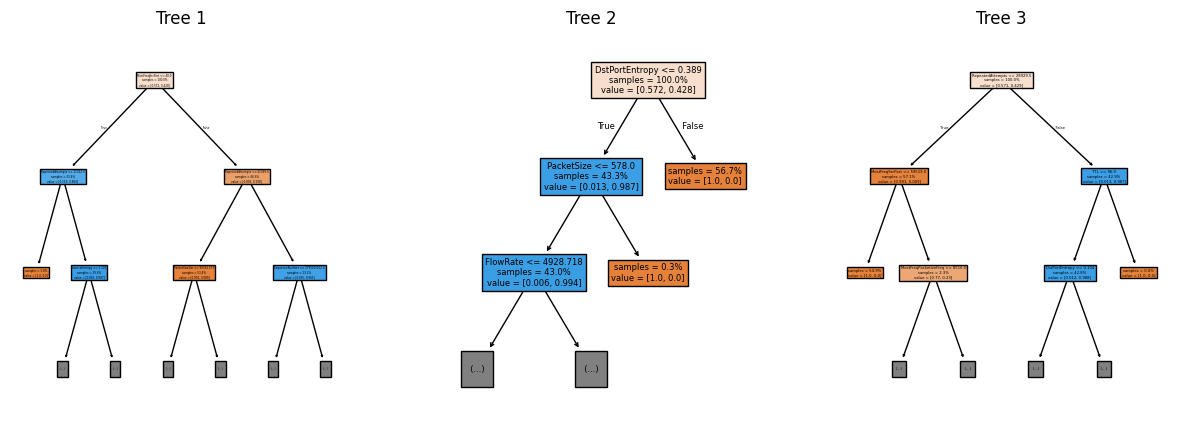

'\n# Ottimizzazione degli iperparametri\nbest_rf = optimize_hyperparameters(X_train, y_train)\n\n# Valutazione del modello ottimizzato\ny_pred_optimized = evaluate_model(best_rf, X_test, y_test) #dovrei aggiungere la soglia anche qua ma per il momento non eseguo\n\n# Visualizzazione della matrice di confusione\ndisplay_confusion_matrix(y_test, y_pred_optimized) \n\n# Salvataggio del modello ottimizzato\nsave_model(best_rf, "RandomForest_optimized_model.pkl")\n'

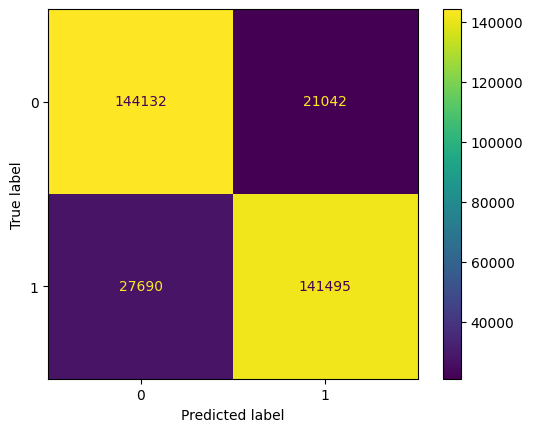

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.tree import export_graphviz
import graphviz
import pickle
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def load_data(filepath):
    data = pd.read_csv(filepath)
    X = data.drop('Label', axis=1)
    y = data['Label']
    return X, y

def save_model(model, filepath):
    try:
        with open(filepath, "wb") as f:
            pickle.dump({"randomforest_model": model}, f)
    except Exception as e:
        print(f"Error saving model: {e}")

def evaluate_model(model, X_test, y_test, threshold =0.5):
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilità per la classe 1
    y_pred = (y_pred_proba >= threshold).astype(int)  # Soglia modificabile

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auroc = roc_auc_score(y_test, y_pred_proba)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Area Under the ROC Curve (AUROC):", auroc)

    return y_pred

def visualize_trees(model, X_train):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    for i in range(3):
        plot_tree(model.estimators_[i], feature_names=X_train.columns, filled=True, max_depth=2, impurity=False, proportion=True, ax=axes[i])
        axes[i].set_title(f'Tree {i+1}')
    plt.show()



def optimize_hyperparameters(X_train, y_train):
    param_dist = {'n_estimators': randint(50, 500), 'max_depth': randint(1, 20)}
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5, verbose=10)
    rand_search.fit(X_train, y_train)
    best_rf = rand_search.best_estimator_
    print('Best hyperparameters:', rand_search.best_params_)
    return best_rf

def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Caricamento dei dati
#UTILIZZO X,Y TRAIN E TEST definiti nello splitting sopra
#X, y = load_data('features_data.csv')
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creazione e addestramento del modello
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Salvataggio del modello
save_model(rf, "RandomForest_model.pkl")

# Valutazione del modello
y_pred = evaluate_model(rf, X_test, y_test, threshold=0.01)

# Visualizzazione degli alberi di decisione
visualize_trees(rf, X_train)

# Visualizzazione della matrice di confusione senza aspettare l'ottimizzazione 
display_confusion_matrix(y_test, y_pred)

"""
# Ottimizzazione degli iperparametri
best_rf = optimize_hyperparameters(X_train, y_train)

# Valutazione del modello ottimizzato
y_pred_optimized = evaluate_model(best_rf, X_test, y_test) #dovrei aggiungere la soglia anche qua ma per il momento non eseguo

# Visualizzazione della matrice di confusione
display_confusion_matrix(y_test, y_pred_optimized) 

# Salvataggio del modello ottimizzato
save_model(best_rf, "RandomForest_optimized_model.pkl")
"""

# 6 iForest

In [14]:
#DA PROBLEMI ACCURACY BASSA
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.metrics import make_scorer

data = pd.read_csv('features_data.csv')

# Split data into features and target
X = data.drop('Label', axis=1)
y = data['Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Determine the number of available CPU cores and limit to a reasonable number
n_cores = min(os.cpu_count(), 2)  # Limit to 2 cores for resource-constrained devices

# Define hyperparameter search space
param_grid = {
    'n_estimators': list(range(100, 800, 25)),
    'max_samples': ['auto', 100, 200],
    'contamination': [0.01, 0.05, 0.1]
}

# Define custom scorer (f1_score)
f1_scorer = make_scorer(f1_score, average='micro')

# Define isolation forest classifier
clf = IsolationForest()

# Perform randomized search for best model
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30,
                                   scoring=f1_scorer, cv=5, verbose=10, n_jobs=n_cores, random_state=47)



best_model = random_search.fit(X_train, y_train)

print("Best model: ")
print(best_model)
# Print optimum parameters
print('\nOptimum parameters:', best_model.best_params_)

# Generate predictions with the best model
y_pred = best_model.predict(X_test)

# Save Model
try:
    with open("BestisolationForest_model.pkl", "wb") as f:
        pickle.dump({
            "isolationforest_model": best_model
            }, f)
except Exception as e:
    print(f"Error saving model: {e}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 2/5; 1/30] START contamination=0.01, max_samples=auto, n_estimators=350.....
[CV 1/5; 1/30] START contamination=0.01, max_samples=auto, n_estimators=350.....
[CV 2/5; 1/30] END contamination=0.01, max_samples=auto, n_estimators=350;, score=0.369 total time=   8.5s
[CV 1/5; 1/30] END contamination=0.01, max_samples=auto, n_estimators=350;, score=0.367 total time=   8.5s
[CV 3/5; 1/30] START contamination=0.01, max_samples=auto, n_estimators=350.....
[CV 4/5; 1/30] START contamination=0.01, max_samples=auto, n_estimators=350.....
[CV 4/5; 1/30] END contamination=0.01, max_samples=auto, n_estimators=350;, score=0.373 total time=   8.5s
[CV 3/5; 1/30] END contamination=0.01, max_samples=auto, n_estimators=350;, score=0.368 total time=   8.5s
[CV 5/5; 1/30] START contamination=0.01, max_samples=auto, n_estimators=350.....
[CV 1/5; 2/30] START contamination=0.01, max_samples=auto, n_estimators=225.....
[CV 1/5; 2/30] END conta

# 7 CNN

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

#data = pd.read_csv('features_data.csv')

# Split data into features and target
#X = data.drop('Label', axis=1)
#y = data['Label']

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Come DATI considero quelli nello splitting sopra

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for 1D CNN
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Build the 1D CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

# Calculate F1 Score
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

import pickle

model.save('cnn.h5')  # Saves as an HDF5 file
model.save('cnn.pkl')
# Assuming 'scaler' is your StandardScaler instance
with open('cnn_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

2024-09-25 21:24:56.538701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
41795/41795 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.9991 - loss: 0.0047 - precision: 0.9982 - recall: 0.9997 - val_accuracy: 0.9741 - val_loss: 0.3178 - val_precision: 0.9999 - val_recall: 0.9388
Epoch 2/10
41795/41795 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 1.0000 - loss: 3.2429e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9741 - val_loss: 0.7470 - val_precision: 1.0000 - val_recall: 0.9388
Epoch 3/10
41795/41795 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 1.0000 - loss: 1.1787e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9743 - val_loss: 0.3513 - val_precision: 1.0000 - val_recall: 0.9393
Epoch 4/10
41795/41795 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 1.0000 - loss: 1.3126e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9741 - val_loss: 0.8544 - val_precision: 1.0000 - val_recall: 0.9388
Epoch 5/10
41795/41795 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 1.0000 - loss: 1.2339e-04 - precision: 1.0000 - recall: 1.0

F1 Score: 0.500621228257011


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=cnn.pkl.